# Imports

In [0]:
import numpy as np
import pandas as pd
import os
import time

from xgboost import XGBClassifier
from xgboost import plot_importance
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Mount Google Drive

In [0]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

# Load the raw data

In [0]:
# Data paths
train_path=os.path.join('train.csv')
test_path=os.path.join('test.csv')

# Load data into pandas dataframes
trainSet = pd.read_csv(train_path)
testSet = pd.read_csv(test_path)

# Visualise the data

In [107]:
print(trainSet.describe())
trainSet.head()

                 id       feat_1  ...       feat_92       feat_93
count  61878.000000  61878.00000  ...  61878.000000  61878.000000
mean   30939.500000      0.38668  ...      0.380119      0.126135
std    17862.784315      1.52533  ...      0.982385      1.201720
min        1.000000      0.00000  ...      0.000000      0.000000
25%    15470.250000      0.00000  ...      0.000000      0.000000
50%    30939.500000      0.00000  ...      0.000000      0.000000
75%    46408.750000      0.00000  ...      0.000000      0.000000
max    61878.000000     61.00000  ...     19.000000     87.000000

[8 rows x 94 columns]


,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,1,0,4,1,1,0,0,2,0,0,0,0,0,1,0,0,0,0,...,0,0,2,0,0,11,0,1,1,0,1,0,7,0,0,0,1,0,0,0,0,0,0,0,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,2,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,6,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,7,2,2,0,0,0,58,0,10,0,0,0,0,0,3,0,...,1,0,0,0,0,0,0,0,0,0,2,1,5,0,0,4,0,0,2,1,0,1,0,0,1,1,2,2,0,22,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,4,0,1,0,0,0,1,0,0,0,0,1,0,0,0,Class_1


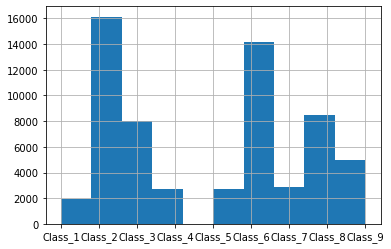

In [108]:
trainSet.target.hist()

[]

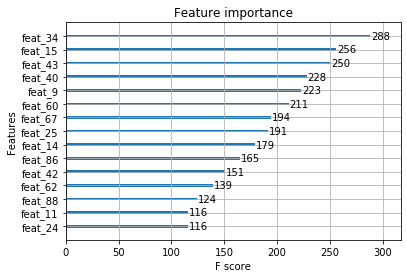

In [124]:
# fit model no training data
model = XGBClassifier()
model.fit(X, Y)
# plot feature importance
plot_importance(model,  max_num_features=15)
plt.plot()

# Clean the data

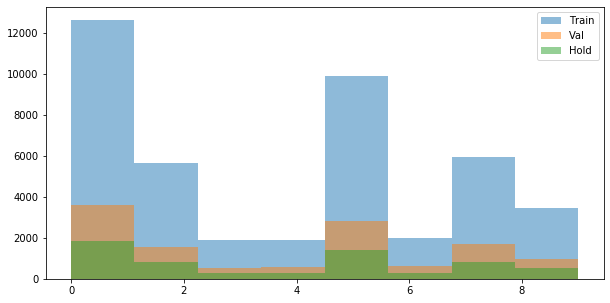

In [278]:
trainDF = trainSet.copy().drop(columns=['id']).sample(frac=1)
trainDF.target = trainDF.target.astype('category').cat.codes

rows, cols = trainDF.shape

trainSize = int(rows*0.7)
valSize = int(rows*0.2)
holdSize = rows - (trainSize + valSize)

train = trainDF.iloc[0:trainSize,:]
val = trainDF.iloc[trainSize:(trainSize+valSize),:]
hold = trainDF.iloc[(trainSize+valSize):,:]

train_features = train.loc[:,train.columns!='target'].values
train_targets = train.target.values

val_features = val.loc[:,val.columns!='target'].values
val_targets = val.target.values

hold_features = hold.loc[:,hold.columns!='target'].values
hold_targets = hold.target.values


bins = np.linspace(0, 9, 9)
plt.figure(figsize=(10, 5))
plt.hist(train_targets, bins, alpha=0.5, label='Train')
plt.hist(val_targets, bins, alpha=0.5, label='Val')
plt.hist(hold_targets, bins, alpha=0.5, label='Hold')
plt.legend(loc='upper right')
plt.show()

In [279]:
set(val.target)

{0, 1, 2, 3, 4, 5, 6, 7, 8}

In [0]:
class CustomDataset(Dataset):

  def __init__(self,features,targets):
    self.features = features
    self.targets = targets
  
  def __len__(self):
    return len(self.features)

  def __getitem__(self,idx):
    return self.features[idx], self.targets[idx]

train_ds = CustomDataset(train_features, train_targets)
val_ds = CustomDataset(val_features, val_targets)
hold_ds = CustomDataset(hold_features, hold_targets)

# Create neural network

In [0]:
class NeuralNetwork(nn.Module):
  
  def __init__(self):
    super(NeuralNetwork, self).__init__()

    self.fc1 = nn.Linear(93, 64)
    self.bn1 = nn.BatchNorm1d(num_features=64)
    self.fc2 = nn.Linear(64, 32)
    self.dropout = nn.Dropout(p=0.5)
    self.fc3 = nn.Linear(32, 16)
    self.fc4 = nn.Linear(16, 9)
  
  def forward(self, x):
    x = self.fc1(x)
    x = self.bn1(x)
    x = torch.relu(x)
    x = self.fc2(x)
    x = self.dropout(x)
    x = torch.relu(x)
    x = self.fc3(x)
    x = torch.relu(x)
    x = self.fc4(x)
    return x

# Training

--------------------------------------------------------------------------------------------
Training:      [epoch: 1]   loss: 1.68    accuracy: 50.07 %
Validation:    [epoch: 1]   loss: 1.11    accuracy: 62.93 %
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
Training:      [epoch: 2]   loss: 0.95    accuracy: 65.69 %
Validation:    [epoch: 2]   loss: 0.85    accuracy: 69.51 %
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
Training:      [epoch: 3]   loss: 0.81    accuracy: 70.55 %
Validation:    [epoch: 3]   loss: 0.77    accuracy: 71.94 %
--------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------

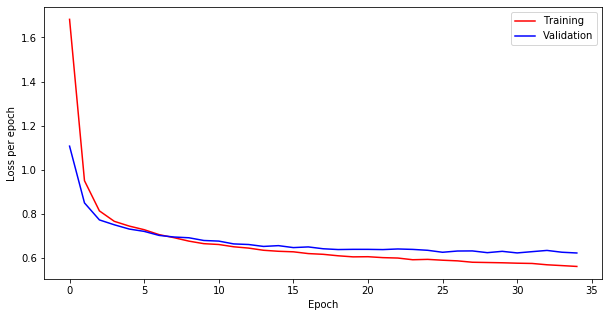

Maximum validation accuracy: 76.90 %


In [328]:
# utilising the gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate=0.001
batch_size = 512
epochs =  100

criterion = nn.CrossEntropyLoss().to(device)

model = NeuralNetwork().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(train_ds, batch_size=batch_size)
val_loader = DataLoader(val_ds, batch_size=len(val_ds))

train_losses = []
val_losses = []
train_accs = []
val_accs = []

minLoss = 9999999
maxAcc = 0

for epoch in range(1,epochs+1):
  running_loss = 0
  running_acc = 0
  for batch, (features,targets) in enumerate(train_loader):
    
    features = features.to(device)
    targets = targets.to(device)

    optimizer.zero_grad()

    outputs = model(features.float())

    loss = criterion(outputs, targets.long())
    running_loss += loss.item()
    
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs.data, 1)
    running_acc += (100*(predicted == targets).sum().item()) / len(train_ds)

  train_losses.append(running_loss/len(train_loader))
  train_accs.append(running_acc)
    
  with torch.no_grad():
    features, targets = next(iter(val_loader))
    features = features.to(device)
    targets = targets.to(device)
    outputs = model(features.float())
    val_loss = criterion(outputs, targets.long()).item()
    val_losses.append(val_loss)
    _, predicted = torch.max(outputs.data, 1)
    val_acc = (100*(predicted == targets).sum().item()) / len(val_ds)
    val_accs.append(val_acc)

  
  if val_acc > maxAcc:
    maxAcc = val_acc
  
  check = np.greater(maxAcc, val_accs[-5:])
  if (check.all() == True) and (epoch>5):
    print('Convergence met')
    break


  print('--------------------------------------------------------------------------------------------')
  print('Training:      [epoch: %d]   loss: %.2f    accuracy: %.2f %%' %(epoch, train_losses[-1], train_accs[-1]))
  print('Validation:    [epoch: %d]   loss: %.2f    accuracy: %.2f %%' %(epoch, val_losses[-1], val_accs[-1]))
  print('--------------------------------------------------------------------------------------------')   


# Plots the loss and accuracy evolution during training 
plt.figure(figsize=(10,5))
plt.plot(train_losses,'r', label='Training')
plt.plot(val_losses, 'b', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss per epoch')
plt.legend()
plt.legend()
plt.show()

print('Maximum validation accuracy: %.2f %%' %(maxAcc))